In [1]:
import time
import numpy as np
import pandas as pd
import random
import os 
import glob
import json
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

/home/sang2001/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Config

In [2]:
torch.manual_seed(2)
np.random.seed(2)
random.seed(2)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_path = "data/images/train/"
val_path = "data/images/val/"
test_path = "data/images/test/"

labels_path = "data/labels/"
save_path = 'save_model'
batch_size = 32
num_epochs = 10

resize = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

classes = ['bike', 'moto']
class_index = {
    '0' : classes[0],
    '1' : classes[1]
}

Load data

In [3]:
print(torch.cuda.is_available())

True


In [4]:
train_dataframe = pd.read_csv(labels_path + "train_labels.txt")
test_dataframe = pd.read_csv(labels_path + "test_labels.txt")
val_dataframe = pd.read_csv(labels_path + "val_labels.txt")

In [5]:
train_dataframe[:10]

,names,labels
0,moto-111.jpg,1
1,moto-419.jpg,1
2,moto-159.jpg,1
3,moto-124.jpg,1
4,moto-568.jpg,1
5,bike-594.jpg,0
6,moto-627.jpg,1
7,bike-269.jpg,0
8,bike-399.jpg,0
9,moto-602.jpg,1


Data Preprocessing

In [6]:
class ImagePreprocessing():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train' : transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.7, 1)),
                transforms.RandomHorizontalFlip(0.5), 
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'test': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [7]:
process_image = ImagePreprocessing(resize, mean, std)

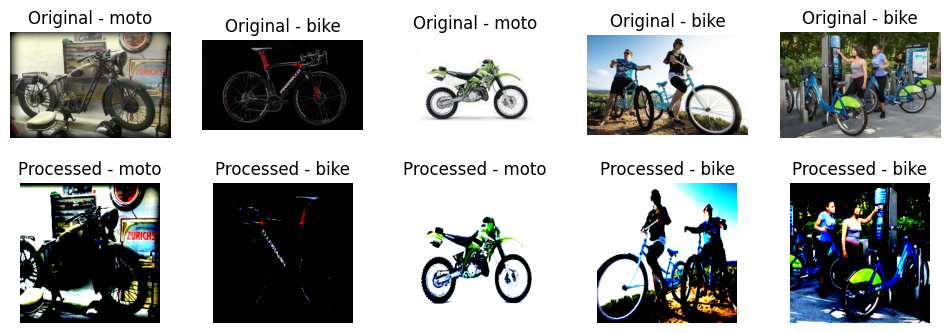

In [8]:
fig = plt.figure(figsize=(12, 4))
rows = 2
cols = 5
for i in range(1, 11):
    if i<6:
        img = Image.open(train_path+train_dataframe['names'][i+3])
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Original - {class_index[str(train_dataframe['labels'][i+3])]}")

    else:
        img = Image.open(train_path+train_dataframe['names'][i-2])
        img_transformed = process_image(img, phase="train")
        #(channel, height, width) -> (height, width, channel) - > (0,1)
        img_transformed = img_transformed.numpy().transpose(1, 2, 0)
        img_transformed = np.clip(img_transformed, 0, 1)
        fig.add_subplot(rows, cols, i)
        plt.imshow(img_transformed)
        plt.axis('off')
        plt.title(f"Processed - {class_index[str(train_dataframe['labels'][i-2])]}")
plt.show()


In [9]:
class MyDataset(data.Dataset):
    def __init__(self, data_frame, path, transform = None, phase = None):
        self.data_frame = data_frame
        self.path = path 
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.data_frame["names"])
    
    def __getitem__(self, index):
        image_path = self.data_frame["names"][index]
        image_label = self.data_frame["labels"][index]
        img = Image.open(self.path + image_path)
        img_transformed = self.transform(img, self.phase)
        return img_transformed, image_label

In [10]:
train_dataset = MyDataset(train_dataframe, train_path, transform= ImagePreprocessing(resize, mean, std), phase= 'train')
val_dataset = MyDataset(val_dataframe, val_path, transform= ImagePreprocessing(resize, mean, std), phase= 'val')

Prepare data

In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, len(val_dataset), shuffle=False)

dataloader_dict = {
                    "train" : train_dataloader,  
                    "val"   : val_dataloader
                }

Load model (Resnet50)

In [12]:
net = models.resnet50(True)
net.fc = nn.Linear(in_features=2048, out_features=2) 

/home/sang2001/anaconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/sang2001/anaconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Loss function

In [14]:
loss_function = nn.CrossEntropyLoss()


Optimization

In [15]:
def update_params(net):
    params_to_update = []
    update_params_name = ["fc.weight", "fc.bias"]
    for name, param in net.named_parameters(): # run though whole the name of layers
        if name in update_params_name:
            param.requires_grad = True # Enable modifying params in update_params_name.
            params_to_update.append(param)
        else:
            param.requires_grad = False
    return params_to_update

In [16]:
params = update_params(net)
optimizer = optim.SGD(params= params, lr= 0.001, momentum= 0.9)

Train model

In [17]:
def train_model(net, dataloader_dict, criterior, optimizer, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device: ", device)
    start_time = time.time()

    for epoch in range(1, num_epochs+1):
        # move network to device(GPU/CPU)
        net.to(device)
        torch.backends.cudnn.benchmark = True
        for phase in ["train", "val"]:
            if phase == "train":
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            if (epoch == 0) and (phase == "train"):
                continue
            for batch_idx, (inputs, labels) in enumerate(dataloader_dict[phase]): 
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = net(inputs)
                    loss = criterior(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item()*inputs.size(0)
                    epoch_corrects += torch.sum(preds==labels.data)
                    if batch_idx % 4 == 0 and phase=="train": 
                        print(f"Epoch: {epoch}/{num_epochs} | Batch: {batch_idx}/{len(dataloader_dict[phase])} | Loss_batch: {loss}")
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_accuracy = epoch_corrects.double() / len(dataloader_dict[phase].dataset)            
            print("{}: Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_accuracy))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        print('------------------------------------------------------------')
        torch.save(net.state_dict(), save_path + "/weight-.pth")
           

In [18]:
train_model(net, dataloader_dict, loss_function, optimizer, num_epochs)

device:  cuda:0
Epoch: 1/10 | Batch: 0/32 | Loss_batch: 0.7406924962997437
Epoch: 1/10 | Batch: 4/32 | Loss_batch: 0.6112226843833923
Epoch: 1/10 | Batch: 8/32 | Loss_batch: 0.5097777843475342
Epoch: 1/10 | Batch: 12/32 | Loss_batch: 0.390545129776001
Epoch: 1/10 | Batch: 16/32 | Loss_batch: 0.37685301899909973
Epoch: 1/10 | Batch: 20/32 | Loss_batch: 0.26232147216796875
Epoch: 1/10 | Batch: 24/32 | Loss_batch: 0.272936075925827
Epoch: 1/10 | Batch: 28/32 | Loss_batch: 0.16155897080898285
train: Loss: 0.3879 Acc: 0.8430
val: Loss: 0.1792 Acc: 0.9552
Time elapsed: 0.40 min
------------------------------------------------------------
Epoch: 2/10 | Batch: 0/32 | Loss_batch: 0.26469647884368896
Epoch: 2/10 | Batch: 4/32 | Loss_batch: 0.17809249460697174
Epoch: 2/10 | Batch: 8/32 | Loss_batch: 0.1310717910528183
Epoch: 2/10 | Batch: 12/32 | Loss_batch: 0.12135796993970871
Epoch: 2/10 | Batch: 16/32 | Loss_batch: 0.2860255837440491
Epoch: 2/10 | Batch: 20/32 | Loss_batch: 0.2523369789123535


Prediction

In [19]:
def load_model(net, model_path):
    load_weights = torch.load(model_path,  map_location={"cuda:0": "cpu"})
    net.load_state_dict(load_weights)
    return net


In [20]:
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    transpose_npimg = np.transpose(npimg, (1, 2, 0))
    img_transformed = np.clip(transpose_npimg, 0, 1)
    plt.imshow(transpose_npimg)
    plt.show()

In [21]:
def draw_confusion(y_true, y_pred):
    cm = confusion_matrix(y_true.cpu().numpy(), y_pred.cpu().numpy() )
    # plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(2)+.5, classes, rotation=90)
    plt.yticks(np.arange(2)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


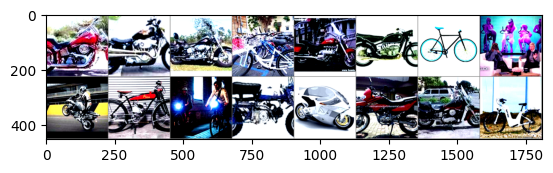

pred-labels:  tensor([1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
true-lables:  tensor([1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
test-accuracy: 96.5%


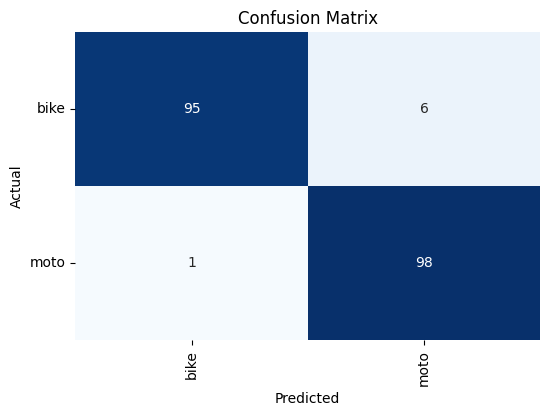

In [22]:
def testAccuracy():
    test_dataset = MyDataset(test_dataframe, test_path, transform= ImagePreprocessing(resize, mean, std), phase= 'test')
    test_dataloader = torch.utils.data.DataLoader(test_dataset, len(test_dataset), shuffle=True)
    model = load_model(net, 'save_model/weight-.pth')
    model.eval()
    accuracy = 0.0
    total = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        model.to(device)
        for data in test_dataloader:
            images, y_true = data
            images = images.to(device)
            y_true = y_true.to(device)
            
            outputs = model(images)
            _, y_pred = torch.max(outputs.data, 1)
            total += y_true.size(0)
            accuracy += (y_pred == y_true).sum().item()
    accuracy = (100 * accuracy / total)
    imageshow(torchvision.utils.make_grid(images.cpu()[0:16]))
    print('pred-labels: ', y_pred[0:16])
    print('true-lables: ', y_true[0:16])
    print(f'test-accuracy: {accuracy}%')
    draw_confusion(y_true, y_pred)
    
testAccuracy()

In [23]:
class Other_Mydataset(data.Dataset):
    def __init__(self, path, transform = None, phase = None):
        self.path = path 
        self.transform = transform
        self.phase = phase
    def __len__(self):
        return 1
    
    def __getitem__(self, index):

        img = Image.open(self.path)
        img_transformed = self.transform(img, self.phase)
        return img_transformed

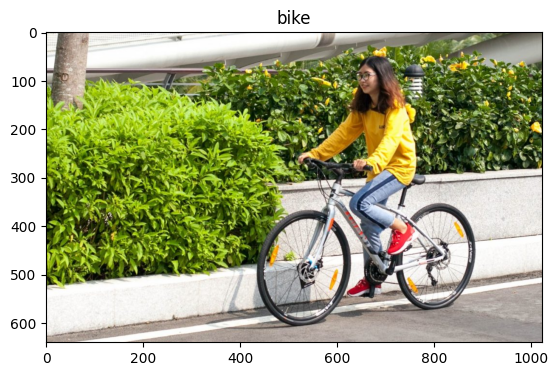

In [24]:
def other_images_test(other_image_path):
    other_dataset = Other_Mydataset(other_image_path, transform= ImagePreprocessing(resize, mean, std), phase= 'test')
    other_dataloader = torch.utils.data.DataLoader(other_dataset)
    model = load_model(net, 'save_model/weight-.pth')
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        model.to(device)
        for image in other_dataloader:

            image = image.to(device)
            
            outputs = model(image)
            _, predicted = torch.max(outputs.data, 1)
    img = Image.open(other_image_path)
    plt.imshow(img)
    plt.title(class_index[str(predicted.cpu().numpy()[0])])
    plt.show()
other_images_test("data/another_test_images/img_2.jpg")